In [1]:
from utils.dataframes import *
from utils.runtime    import setup_plot_params

setup_plot_params()

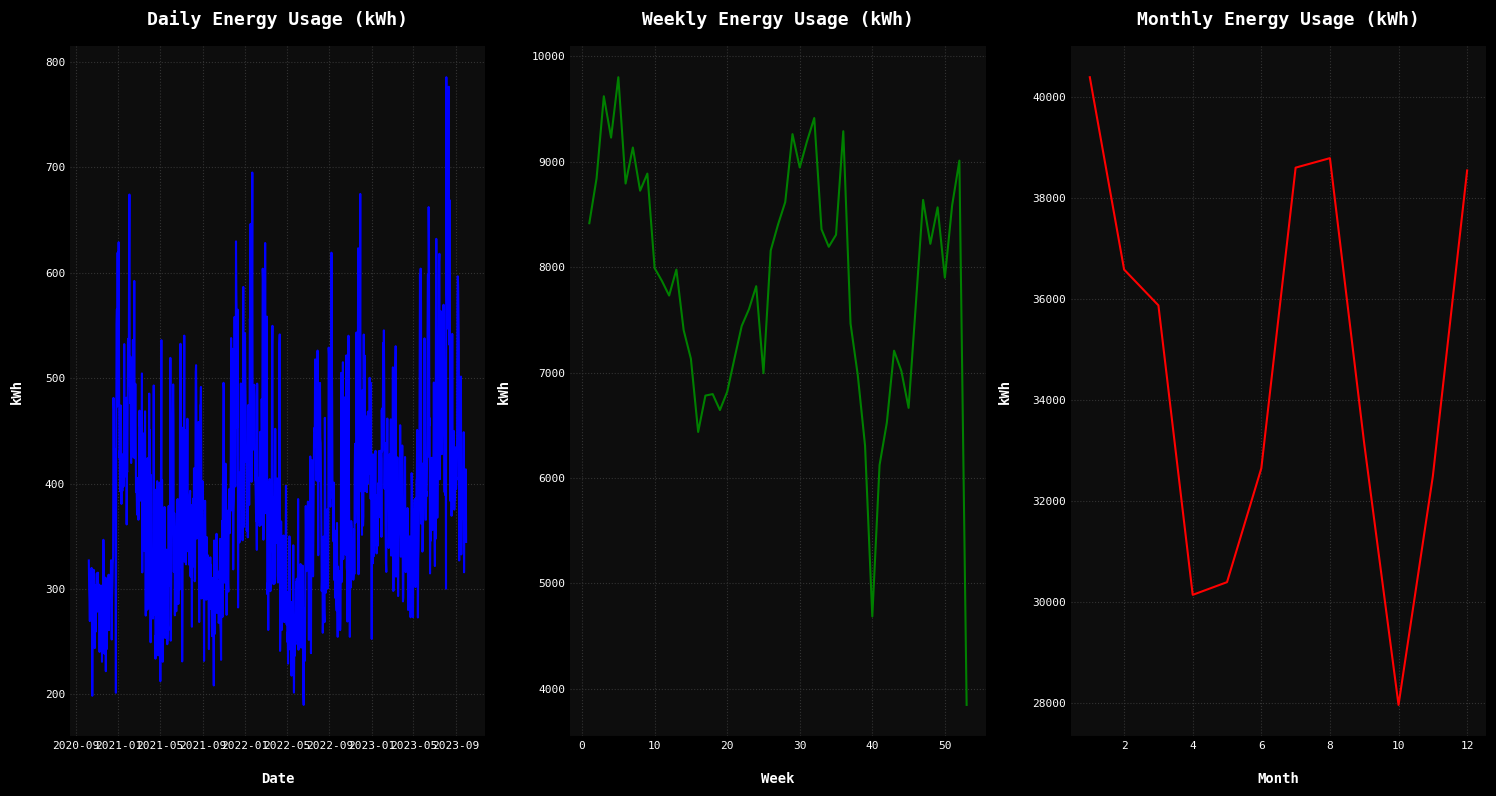

In [2]:
import matplotlib.pyplot as plt
import pandas  as pd
import seaborn as sns

# Script for Temporal Energy Usage Analysis

# Merging the fct_electric_brew with dim_datetimes for temporal analysis
temporal_data = pd.merge(fct_electric_brew, 
                         dim_datetimes, left_on='dim_datetimes_id', right_on='id', how='left')

# Converting timestamp to datetime
temporal_data['timestamp'] = pd.to_datetime(temporal_data['timestamp'])

# Aggregate kWh by different time periods
daily_usage = temporal_data.groupby(temporal_data['timestamp'].dt.date)['kwh'].sum()
weekly_usage = temporal_data.groupby(temporal_data['week'])['kwh'].sum()
monthly_usage = temporal_data.groupby(temporal_data['month'])['kwh'].sum()

# Plotting
plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
daily_usage.plot(title='Daily Energy Usage (kWh)', color='blue')
plt.xlabel('Date')
plt.ylabel('kWh')

plt.subplot(1, 3, 2)
weekly_usage.plot(title='Weekly Energy Usage (kWh)', color='green')
plt.xlabel('Week')
plt.ylabel('kWh')

plt.subplot(1, 3, 3)
monthly_usage.plot(title='Monthly Energy Usage (kWh)', color='red')
plt.xlabel('Month')
plt.ylabel('kWh')

plt.tight_layout()
plt.show()


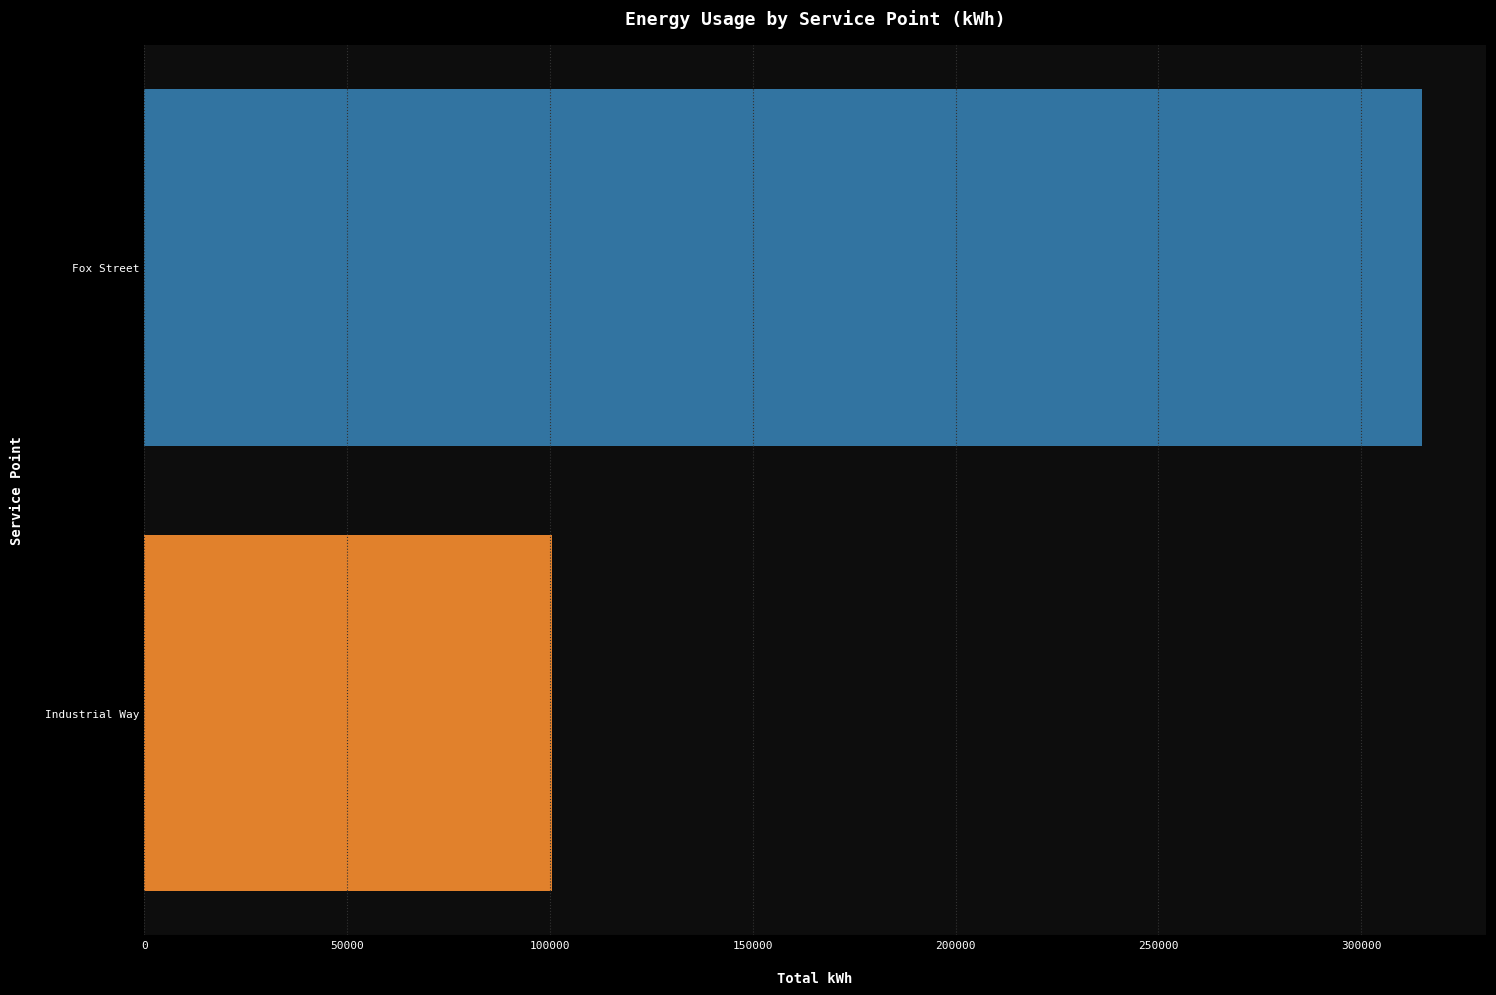

In [3]:
# Script for Geographical Energy Usage Analysis

# Merging the fct_electric_brew with dim_meters for geographical analysis
geo_data = pd.merge(fct_electric_brew, dim_meters, left_on='dim_meters_id', right_on='id', how='left')

# Aggregate kWh by service points (using 'label' as the geographical identifier)
geo_usage = geo_data.groupby('label')['kwh'].sum().sort_values(ascending=False)

# Plotting
sns.barplot(x=geo_usage.values, y=geo_usage.index, hue = geo_usage.index)
plt.title('Energy Usage by Service Point (kWh)')
plt.xlabel('Total kWh')
plt.ylabel('Service Point')
plt.show()

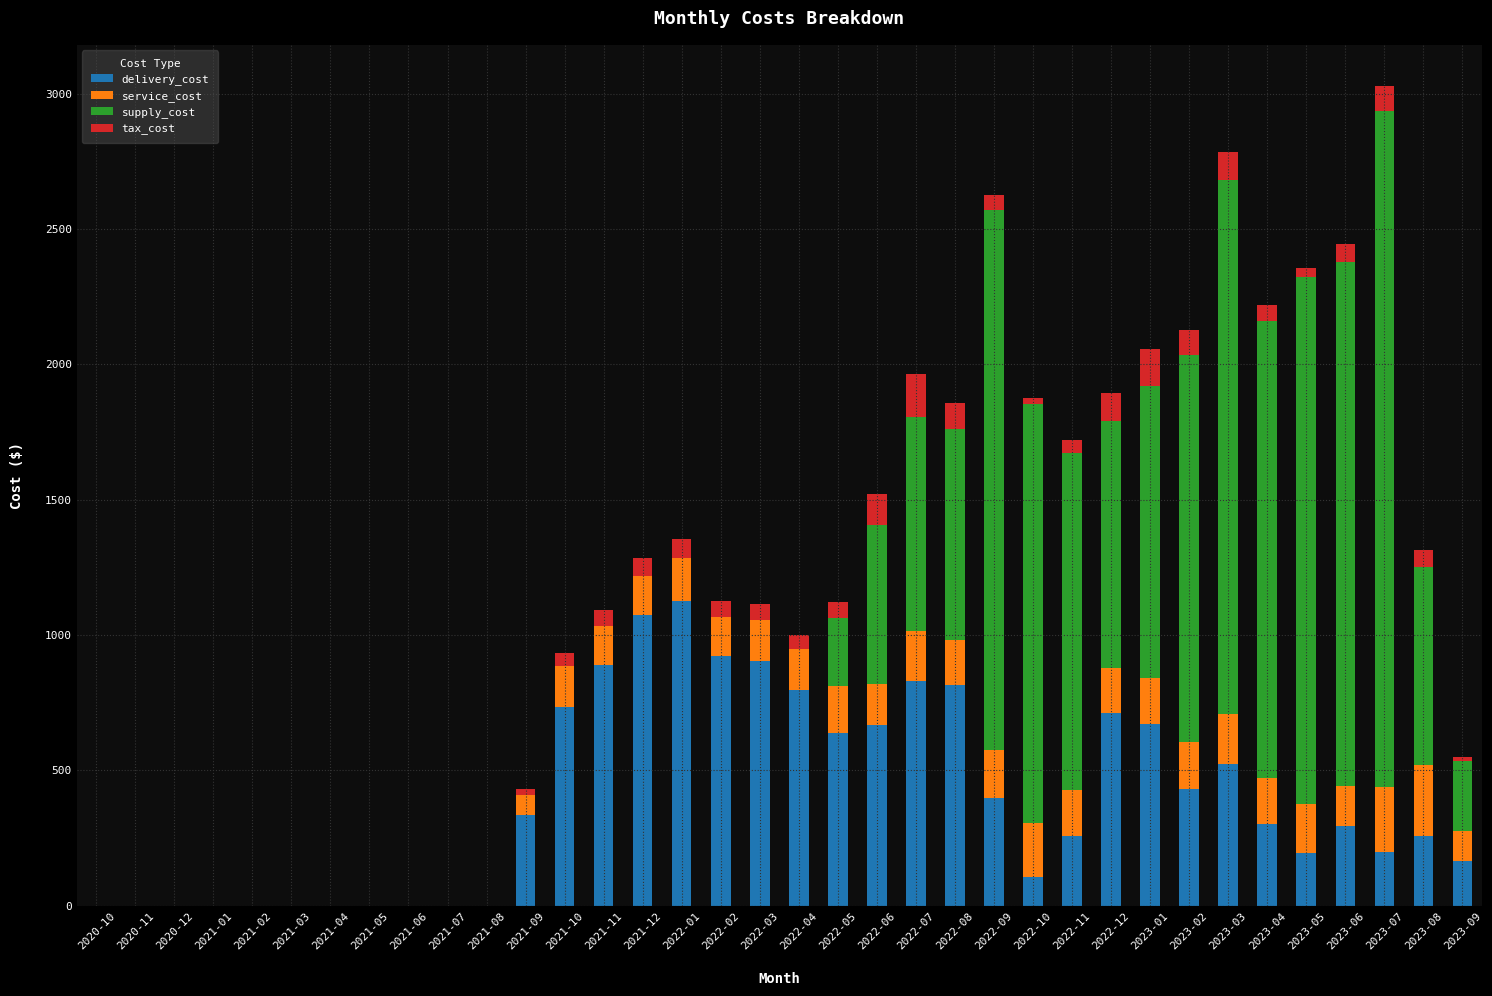

In [13]:
# Revised Script for Billing and Cost Analysis

# Merging the fct_electric_brew with dim_datetimes for monthly cost breakdown
billing_temporal_data = pd.merge(fct_electric_brew, dim_datetimes, left_on='dim_datetimes_id', right_on='id', how='left')

# Converting date to datetime and aggregating costs over time (monthly)
billing_temporal_data['date'] = pd.to_datetime(billing_temporal_data['date'])
monthly_costs = billing_temporal_data.groupby(billing_temporal_data['date'].dt.to_period('M')).agg({
    'delivery_cost' : 'sum',
    'service_cost': 'sum',
    'supply_cost': 'sum',
    'tax_cost': 'sum'
})

# Plotting Monthly Costs
monthly_costs.plot(kind='bar', stacked=True)
plt.title('Monthly Costs Breakdown')
plt.xlabel('Month')
plt.ylabel('Cost ($)')
plt.legend(title='Cost Type')
plt.xticks(rotation=45)
plt.show()


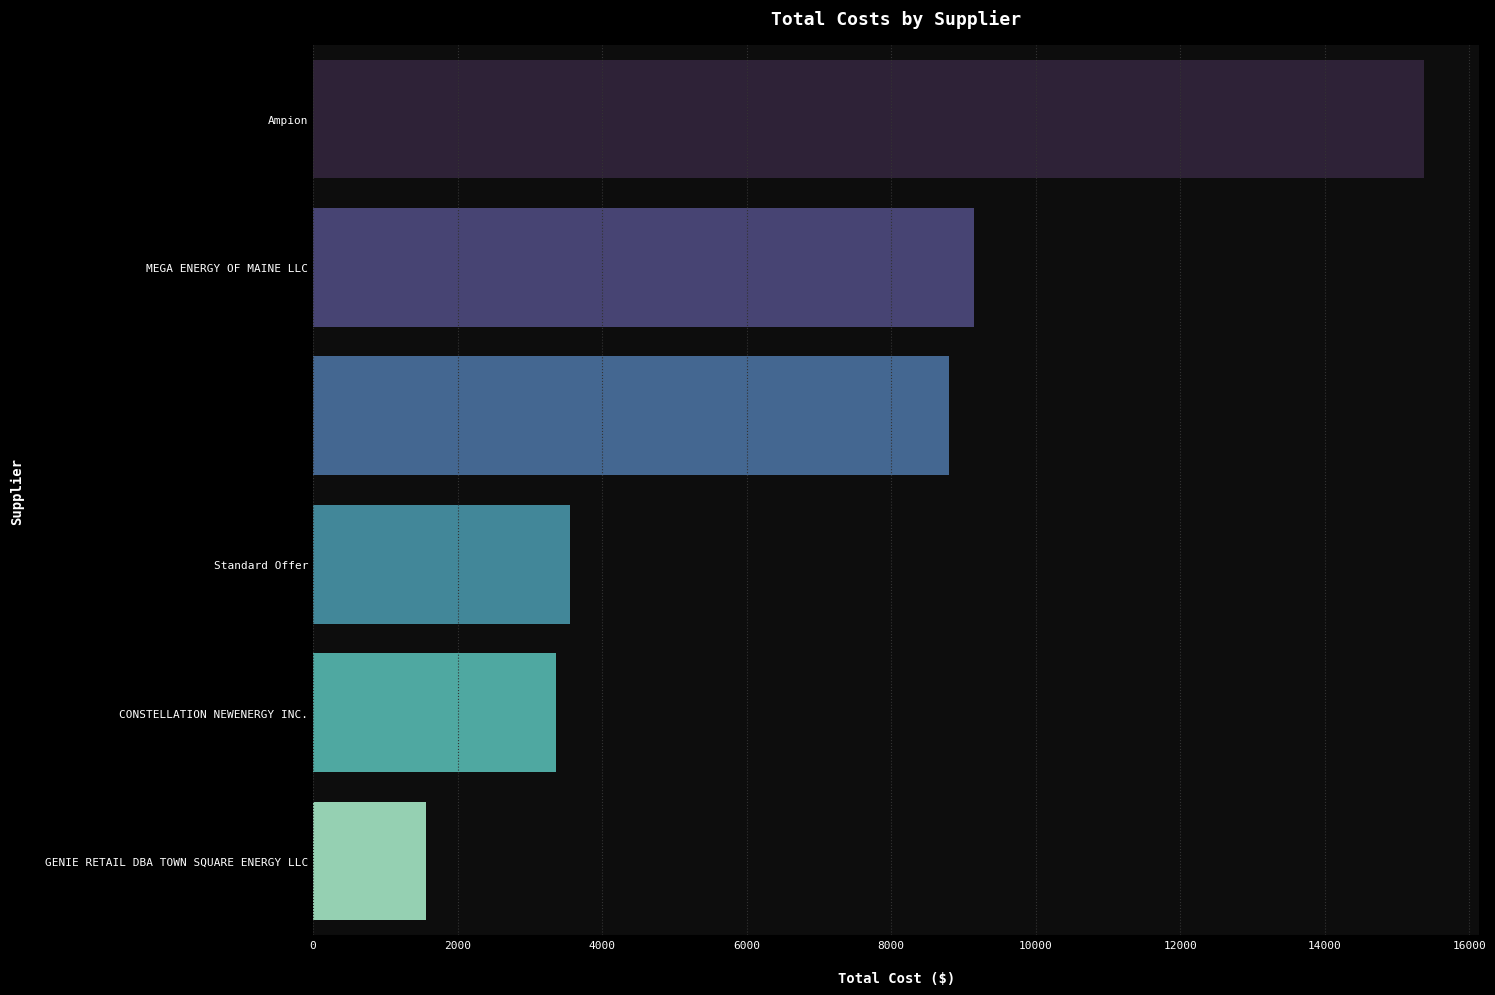

In [11]:
# Merging fct_electric_brew with dim_bills for supplier cost analysis
supplier_data = pd.merge(fct_electric_brew, dim_bills, left_on='dim_bills_id', right_on='id', how='left')

# Comparing costs across different suppliers
supplier_costs = supplier_data.groupby('supplier')['total_cost'].sum().sort_values(ascending=False)

# Plotting Supplier Costs
sns.barplot(x=supplier_costs.values, y=supplier_costs.index, hue=supplier_costs.index, palette="mako")
plt.title('Total Costs by Supplier')
plt.xlabel('Total Cost ($)')
plt.ylabel('Supplier')
plt.show()

/opt/homebrew/Caskroom/miniconda/base/envs/electric-brew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/electric-brew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/electric-brew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


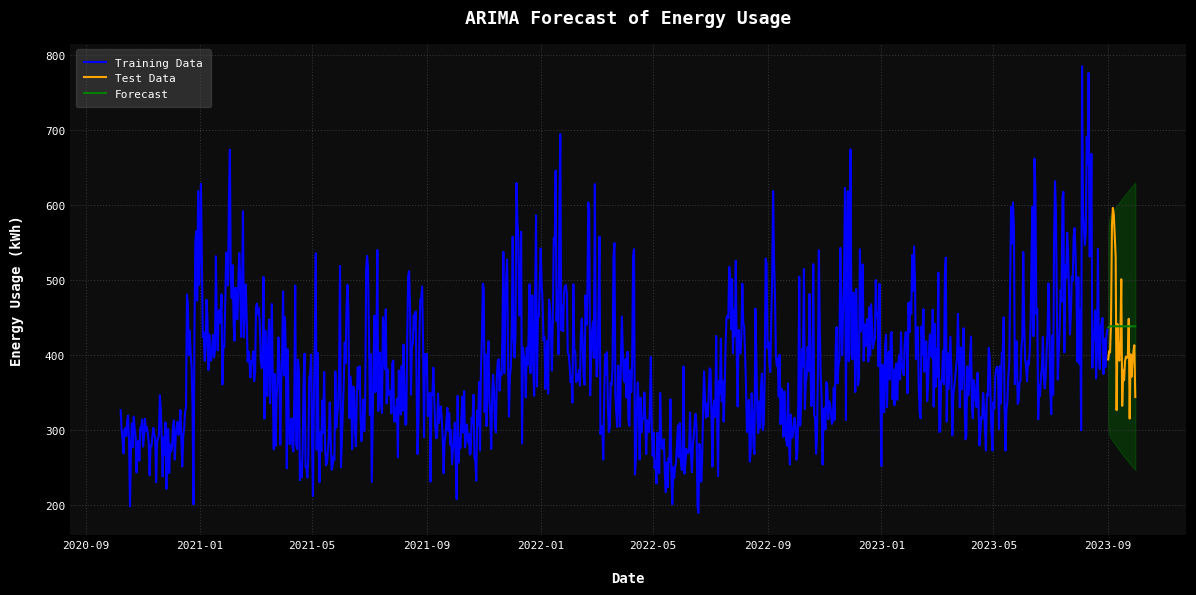

In [6]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Script for Time Series Forecasting using ARIMA

# Aggregating daily energy usage for ARIMA modeling
daily_energy_usage = temporal_data.groupby(temporal_data['timestamp'].dt.date)['kwh'].sum()

# Splitting the data into training and testing sets (last 30 days for testing)
train_data = daily_energy_usage[:-30]
test_data = daily_energy_usage[-30:]

# Fitting the ARIMA model
# Using a simple (1,1,1) order for demonstration, but this should be fine-tuned
arima_model = ARIMA(train_data, order=(1, 1, 1))
arima_result = arima_model.fit()

# Forecasting the next 30 days
forecast = arima_result.get_forecast(steps=30)
forecast_index = test_data.index
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plotting the forecast against the actual data
plt.figure(figsize=(12, 6))
train_data.plot(label='Training Data', color='blue')
test_data.plot(label='Test Data', color='orange')
plt.plot(forecast_index, forecast_mean, label='Forecast', color='green')
plt.fill_between(forecast_index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='green', alpha=0.3)
plt.title('ARIMA Forecast of Energy Usage')
plt.xlabel('Date')
plt.ylabel('Energy Usage (kWh)')
plt.legend()
plt.show()



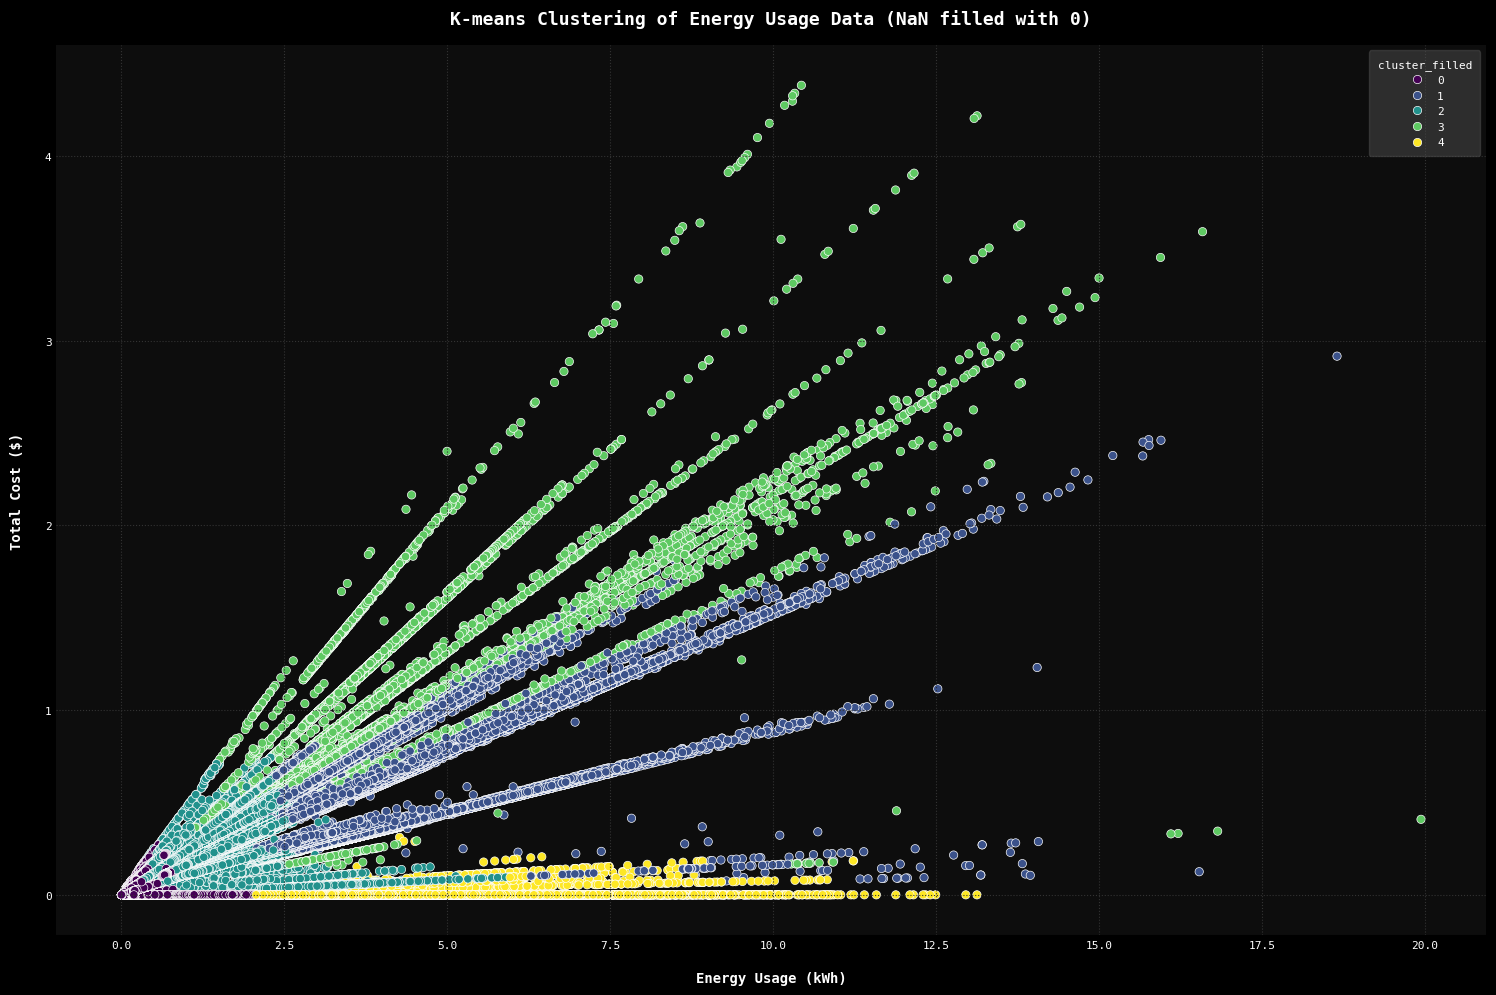

In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Script for Cluster Analysis using K-means

# Selecting relevant features for clustering
# Using 'kwh', 'delivery_cost', 'service_cost', 'supply_cost' for clustering
cluster_data = fct_electric_brew[['kwh', 'delivery_cost', 'service_cost', 'supply_cost']]

# Standardizing the data
scaler = StandardScaler()
# Handling NaN values in the cluster data
cluster_data_filled = cluster_data.fillna(0)

# Standardizing the filled data
cluster_scaled_filled = scaler.fit_transform(cluster_data_filled)

# Re-applying K-means clustering with filled NaN values
kmeans_filled = KMeans(n_clusters=5, random_state=0, n_init = 'auto')
clusters_filled = kmeans_filled.fit_predict(cluster_scaled_filled)

# Adding the cluster labels to the original data
fct_electric_brew['cluster_filled'] = clusters_filled

# Plotting the results with filled NaN values
sns.scatterplot(data=fct_electric_brew, x='kwh', y='total_cost', hue='cluster_filled', palette='viridis')
plt.title('K-means Clustering of Energy Usage Data (NaN filled with 0)')
plt.xlabel('Energy Usage (kWh)')
plt.ylabel('Total Cost ($)')
plt.show()




In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Script for Regression Analysis

# Preparing the data for regression
# Using 'kwh', 'delivery_cost', 'service_cost', 'supply_cost' as features and 'total_cost' as the target
regression_data = fct_electric_brew[['kwh', 'delivery_cost', 'service_cost', 'supply_cost', 'total_cost']].dropna()

# Defining features and target variable
X = regression_data[['kwh', 'delivery_cost', 'service_cost', 'supply_cost']]
y = regression_data['total_cost']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fitting the Linear Regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Making predictions on the test set
y_pred = regressor.predict(X_test)

# Calculating the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Outputting the model coefficients and MSE
regression_coefficients = regressor.coef_
mse



2.559091901127399e-05

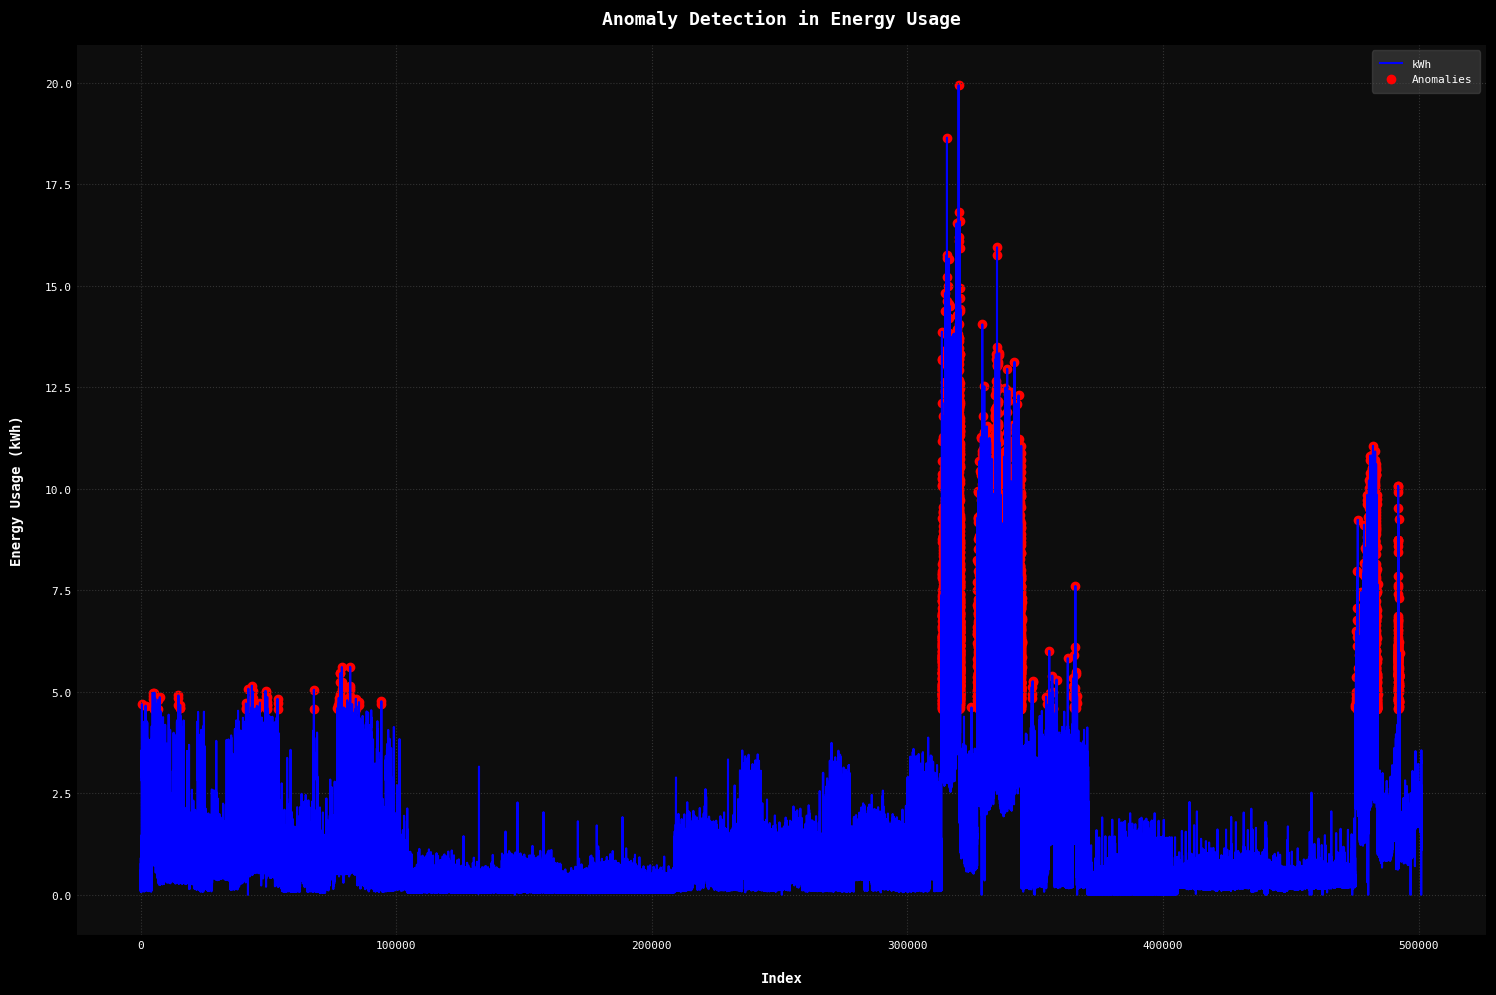

10950

In [15]:
from scipy import stats

# Script for Anomaly Detection

# Using 'kwh' for anomaly detection
anomaly_data = fct_electric_brew['kwh']

# Calculating the z-scores of the kWh data
z_scores = np.abs(stats.zscore(anomaly_data))

# Defining a threshold for identifying anomalies (e.g., z-score > 3)
threshold = 3
anomalies = anomaly_data[z_scores > threshold]

# Plotting the kWh data and highlighting anomalies
plt.plot(anomaly_data, label='kWh', color='blue')
plt.scatter(anomalies.index, anomalies, color='red', label='Anomalies')
plt.title('Anomaly Detection in Energy Usage')
plt.xlabel('Index')
plt.ylabel('Energy Usage (kWh)')
plt.legend()
plt.show()

# Number of identified anomalies
num_anomalies = anomalies.shape[0]
num_anomalies